# ProgPy Tutorial
_2024 PHM Society Conference_
_November, 2024_

Please put questions in the Whova App or raise your hand.

# Pre-Work
_We recommend installing ProgPy prior to the tutorial_

The latest stable release of ProgPy is hosted on PyPi. To install via the command line, use the following command: 

`$ pip install progpy`

The documentation for ProgPy can be found [here](https://nasa.github.io/progpy/index.html). We will reference this material throughout the tutorial. ProgPy can be found on GitHub at [this link](https://github.com/nasa/progpy).

Please download the Whova App (<span style="color:red"> link? </span>) for live Q&A during the session.

Next, lets download the data we will be using for this tutorial. To do this we will use the datasets subpackage in progpy.

In [57]:
from progpy.datasets import nasa_battery
(desc, data) = nasa_battery.load_data(1)

## Introduction to ProgPy

<span style="color:red">
•	Put questions in the whova app
•	What it is
•	Where to find it
•	Installing it – Pre-work
•	General Structure

</span>

NASA’s ProgPy is an open-source python package supporting research and development of prognostics, health management, and predictive maintenance tools. It implements architectures and common functionality of prognostics, supporting researchers and practitioners.

The goal of this tutorial is to instruct users how to use and extend ProgPy. This tutorial will cover how to use a model, including existing models and additional capabilities like parameter estimation and simulation, as well as how to build a new model from scratch. 

### Definitions and Background



The tutorial will begin with an introduction to prognostics and ProgPy using ProgPy's documentation. Please follow along in the [ProgPy Guide](https://nasa.github.io/progpy/guide.html).

### Tutorial Outline

1. Using an existing model
    - Loading a model
    - Model parameters
    - Simulation
    - Noise
    - Prognostics with data

2. Building a new model 
 
<span style="color:red"> update this as we go along ... </span>


## The Dataset

In [2]:
print(desc['description'])

Experiment consisting of repeated iteration of a randomized series of discharging pulses followed by a recharging period of variable length. Batteries are charged and discharged at room temperature


DESCRIPTION ABOUT RUN

In [86]:
print(desc['runs'][5:32])

[{'type': 'D', 'desc': 'reference discharge', 'date': '04-Jan-2014 08:06:47'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 13:43:19'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 14:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 14:13:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 14:33:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 14:43:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 15:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 15:13:19'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 15:33:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 15:43:19'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 'date': '04-Jan-2014 16:03:20'}, {'type': 'R', 'desc': 'pulsed load (rest)', 'date': '04-Jan-2014 16:13:20'}, {'type': 'D', 'desc': 'pulsed load (discharge)', 

For this lets use relative time as the index

SOMETHING ABOUT HOW WE WILL CONCAT MULTIPLE STEPS

In [85]:
import pandas as pd
dataset = pd.concat(data[5:32], ignore_index=True)
print(dataset)

       relativeTime  current  voltage  temperature
0              0.04    1.003    4.040     18.15403
1             10.04    1.000    4.024     18.21702
2             20.04    1.000    4.016     18.32726
3             30.04    1.000    4.009     18.37451
4             40.04    1.000    4.003     18.40600
...             ...      ...      ...          ...
23659        112.04    1.000    3.207     19.90211
23660        113.04    1.000    3.205     19.91786
23661        114.04    1.000    3.202     19.91786
23662        115.04    1.000    3.200     19.91786
23663        115.08    1.000    3.200     19.91786

[23664 rows x 4 columns]


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

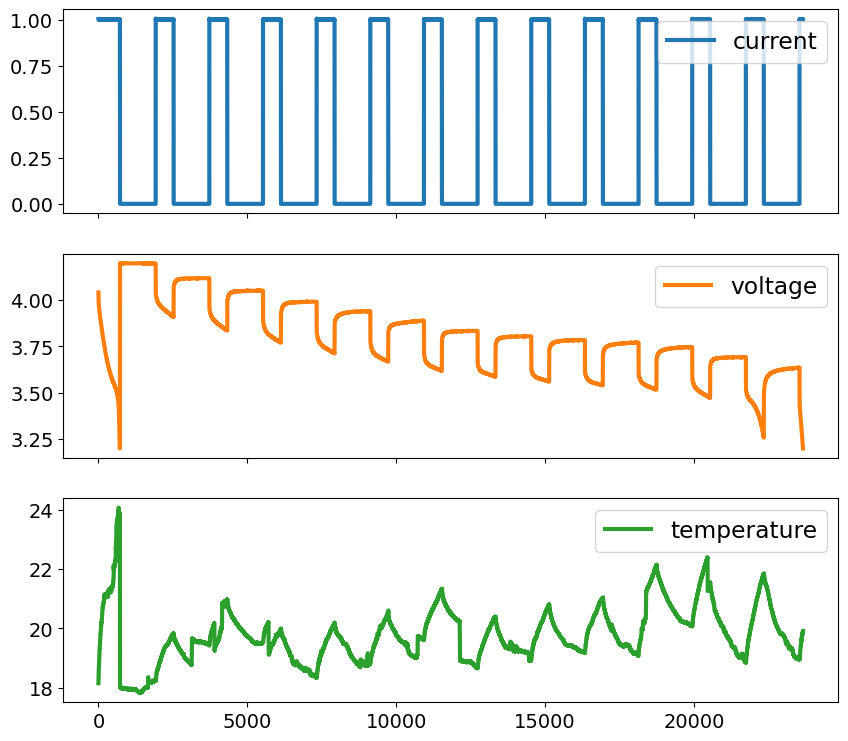

In [87]:
dataset.plot(y=['current', 'voltage', 'temperature'], subplots=True)

## Using an existing Model

<span style="color:red">
•	Introduce- existing models, data driven tools

•	Battery Model – Electrochemistry EOD
•	Set parameters (characterize) using data - Chetan - script for characterization, confirm that data works for that.
        m = BatteryElectroChemEOD()
        m.estimate_params(dataset1, params=[...])
        m.estimate_params(dataset2, params=[...])
        ...
        

•	Simulate 

-   introducing state estimation and prediction as concepts

•	Setup an example with prognostics & data (see dataset example)

•	Surrogate model – build surrogate model, compare runtime
</span>


The first component of ProgPy are the **Prognostics Models**. Models describe the behavior of the system of interest and how the state of the system evolves with use. ProgPy includes capability for prognostics models to be [physics-based](https://nasa.github.io/progpy/glossary.html#term-physics-based-model) or [data-driven](https://nasa.github.io/progpy/glossary.html#term-data-driven-model).

All prognostics models have the same [format](https://nasa.github.io/progpy/prog_models_guide.html#progpy-prognostic-model-format) within ProgPy. The architecture requires definition of model inputs, states, outputs, and events which come together to create a system model.

ProgPy includes a collection of [included models](https://nasa.github.io/progpy/api_ref/progpy/IncludedModels.html#included-models) which can be accessed through the `progpy.models` package.


### Loading a Model

To illustrate how to use a built-in model, let's use the [Battery Electrochemistry model](https://nasa.github.io/progpy/api_ref/progpy/IncludedModels.html#:~:text=class%20progpy.models.BatteryElectroChemEOD(**kwargs)). This model predicts the end-of-discharge of a Lithium-ion battery based on a set of differential equations that describe the electrochemistry of the system [Daigle et al. 2013](https://papers.phmsociety.org/index.php/phmconf/article/view/2252).



First, import the model from the `progpy.models` package.

In [3]:
from progpy.models import BatteryElectroChemEOD

Next, let's create a new battery using the default settings:

In [4]:
batt = BatteryElectroChemEOD()

### Model parameters

Model parameters describe the specific system the model will simulate. For the Electrochemistry model, the default model parameters are for 18650-type Li-ion battery cells. All parameters can be accessed through `batt.parameters`. Let's print out all of the parameters, followed by the specific parameter for the battery's capacity, denoted as `qMax` in this model.

In [ ]:
print(batt.parameters)
print(batt['qMax'])

Parameter values can be configured in various ways. Parameter values can be passed into the constructor as keyword arguments when the model is first instantiated or can be set afterwards, like so:

In [ ]:
batt['qMax'] = 127000
print(batt['qMax'])

In addition to setting model parameter values by hand, ProgPy includes a [parameter estimation](https://nasa.github.io/progpy/prog_models_guide.html#parameter-estimation:~:text=examples.future_loading-,Parameter%20Estimation,-%23) functionality that tunes the parameters of a general model to match the behavior of a specific system. In ProgPy, the `progpy.PrognosticsModel.estimate_params()` method tunes model parameters so that the model provides a good fit to observed data. In the case of the Electrochemistry model, for example, parameter estimation would take the general battery model and configure it so that it more accurately describes a specific battery. The ProgPy documentation includes a [detailed example](https://nasa.github.io/progpy/prog_models_guide.html#parameter-estimation:~:text=See%20the%20example%20below%20for%20more%20details) on how to do parameter estimation.

### Simulation

Once a model has been created, the next step is to simulate it's evolution throughout time. Simulation is the foundation of prediction, but unlike full prediction, simulation does not include uncertainty in the state and other product (e.g., [output](https://nasa.github.io/progpy/glossary.html#term-output)) representation.

*Future Loading*

Most prognostics models have some sort of [input](https://nasa.github.io/progpy/glossary.html#term-input), i.e. a control or load applied to the system that impacts the system state and outputs. For example, for a battery, the current drawn from the battery is the applied load, or input. In this case, to simulate the system, we must define a `future_loading` function that describes how the system will be loaded, or used, throughout time. (Note that not all systems have applied load, e.g. [ThrowObject](https://nasa.github.io/progpy/api_ref/progpy/IncludedModels.html?highlight=thrownobject#progpy.models.ThrownObject), and no `future_loading` is required in these cases.)

ProgPy includes pre-defined [loading functions](https://nasa.github.io/progpy/api_ref/progpy/Loading.html?highlight=progpy%20loading) in `progpy.loading`. Here, we'll implement the built-in piecewise loading functionality. <span style="color:red"> do we want more description of this or just verbal? </span>

In [6]:
from progpy.loading import Piecewise

future_loading = Piecewise(
        InputContainer=batt.InputContainer,
        times=[600, 900, 1800, 3000],
        values={'i': [2, 1, 4, 2, 3]})

*Simulate to Threshold*

With this in mind, we're ready to simulate our model forward in time using ProgPy's [simulation functionality](https://nasa.github.io/progpy/prog_models_guide.html#simulation).

Physical systems frequently have one or more failure modes, and there's often a need to predict the progress towards these events and the eventual failure of the system. ProgPy generalizes this concept of predicting Remaining Useful Life (RUL) with [events](https://nasa.github.io/progpy/prog_models_guide.html#events) and their corresponding thresholds at which they occur. 


Often, there is interest in simulating a system forward in time until a particular event occurs. ProgPy includes this capability with `simulate_to_threshold()`. 

First, let's take a look at what events exist for the Electrochemistry model.

In [ ]:
batt.events

The only event in this model is 'EOD' or end-of-discharge. The `progpy.PrognosticsModel.event_state()` method estimates the progress towards the event, with 1 representing no progress towards the event and 0 indicating the event has occurred.  The method `progpy.PrognosticsModel.threshold_met()` defines when the event has happened. In the Electrochemistry model, this occurs when the battery voltage drops below some pre-defined value, which is stored in the parameter `VEOD`. Let's see what this threshold value is.

In [ ]:
batt.parameters['VEOD']

With these definitions in mind, let's simulate the battery model until threshold for EOD is met. We'll use the same `future_loading` function as above. 

In [11]:
options = { #configuration for this sim
    'save_freq': 100,  # Frequency at which results are saved (s)
    'horizon': 8000  # Maximum time to simulate (s) - This is a cutoff. The simulation will end at this time, or when a threshold has been met, whichever is first
    }
results = batt.simulate_to_threshold(future_loading, **options)

Let's visualize the results. Note that the simulation ends when the voltage value hits the VEOD value of 3.0.

In [ ]:
results.inputs.plot(ylabel='Current drawn (amps)')
results.event_states.plot(ylabel='Battery State of Charge')
results.outputs.plot(ylabel= {'v': "voltage (V)", 't': 'temperature (°C)'}, compact= False)

In addition to simulating to threshold, ProgPy also includes a simpler capability to simulate until a particular time, using `simulate_to()`.

### Noise

A key factor in modeling any real-world application is noise. See the ProgPy [noise documentation](https://nasa.github.io/progpy/prog_models_guide.html#noise) for a detailed description of different types of noise and how to include it in the ProgPy architecture. 

### Prognostics with data



<span style="color:red">
https://nasa.github.io/progpy/prog_algs_guide.html#state-estimation-and-prediction-guide

Note to go to documentation 

- download data from real datasets (from dataset.py)
- each dataset split into many runs; string together a bunch and take this as a single run 
- Plot what load looks like; run through state estimation and prediction and compare to data 
- play around with uncertainty to get bounds right
</span>  

Now that we have a basic simulation of our model, let's make a prediction using the prognostics capabilities within ProgPy. The two basic components of prognostics are [state estimation and prediction](https://nasa.github.io/progpy/prog_algs_guide.html#state-estimation-and-prediction-guide). ProgPy includes functionality to do both. 

To implement a prognostics example, we first need data from our system. We'll use data from <span style="color:red"> INCLUDE REFERENCE and description </span>.

In [ ]:
# Include data here

For the battery electrochemistry model, we'll need to use a [state estimator](https://nasa.github.io/progpy/prog_algs_guide.html#state-estimation) because the model state is not directly measureable, i.e. it has hidden states. We'll use an Unscented Kalman filter and the `estimate` method. ProgPy also includes a Particle Filter and a Kalman Filter.  

First, let's load the necessary imports.

In [ ]:
from progpy.state_estimators import UnscentedKalmanFilter
from progpy.uncertain_data import MultivariateNormalDist

State estimators require an initial state. To define this, we'll first initialize the model and then define the initial state as a distribution of possible states around this using a multi-variate normal distribution. 

In [ ]:
initial_state = batt.initialize() # Initialize model
x_guess = MultivariateNormalDist(initial_state.keys(), initial_state.values(), np.diag([max(x_i*0.1, 0.1) for x_i in initial_state.values()])) # Define distribution around initial state

With our initial distribution defined, we can now instantiate the state estimator.

In [ ]:
ukf = UnscentedKalmanFilter(batt, x_guess)

## Building a new model

In the last sections we described how to tune and use a prognostics model, using a model distributed with ProgPy. However, in many cases a model doesn't yet exist for the system being targeted. In those cases, a new model must be built to describe the behavior and degradation of the system.

In this section we will create a new model from scratch. We will again be using the battery as a target. 

All of the past sections describe how to use an existing model. In this section we will describe how to create a new model. This section specifically describes creating a new physics-based model. NOTE ABOUT SOMETIMES NEEDING TO CREATE A NEW ONE SOMETIME

Physics-based state transition models that cannot be described linearly are constructed by subclassing [progpy.PrognosticsModel](https://nasa.github.io/progpy/api_ref/prog_models/PrognosticModel.html#prog_models.PrognosticsModel). To demonstrate this, we'll create a new model class that inherits from this class. Once constructed in this way, the analysis and simulation tools for PrognosticsModels will work on the new model.
https://nasa.github.io/progpy/prog_models_guide.html#state-transition-models

From here: https://www.sciencedirect.com/science/article/pii/S0951832018301406

In [103]:
from progpy import PrognosticsModel

$R_{int}(k+1) = R_{int}(k) + w_1(k)$

$SOC(k+1) = SOC(k) - P(k)*\Delta t * E_{crit}(k)^{-1} + w_2(k)$

$E_{crit}(k+1) = E_{crit}(k) + w_3(k)$

w1, 2 and 3 are omitted (process noise, which is covered by ProgPy)

Note: wont actually subclass in practice, but it's to demonstrate

In [104]:
class SimplifiedEquivilantCircuit(PrognosticsModel):
    inputs = ['P']
    states = [
        'R_int',
        'SOC',
        'E_crit']

In [105]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    default_parameters = {
        'x0': {
            'R_int': 0.027,
            'SOC': 1,
            'E_crit': 202426.858,
        }
    }

In [106]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    state_limits = {
        'SOC': (0.0, 1.0)
    }

In [107]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    def next_state(self, x, u, dt):
        x['SOC'] = x['SOC'] - u['P'] * dt / x['E_crit']

        return x

$V(k) = v_{oc}(k) - i(k) * R_{int}(k) + \eta (k)$

where

$v_{oc}(k) = v_L + \lambda ^ {\gamma * SOC(k)} - \mu * e ^ {-\beta * \sqrt{SOC(k)}}$

and

$i(k) = \frac{v_{oc}(k) - \sqrt{v_{oc}(k)^2 - 4 * R_{int}(k) * P(k)}}{2 * R_{int}(k)}$

Note that $\eta$ is the measurement noise, which progpy handles, so that's ommitted from the equation below.

In [108]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    outputs = ['v']

Note that the input ($P(k)$) is also used in the output, that means it's part of the state of the system. So we will update the states to include this

In [109]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    states = [
        'R_int',
        'SOC',
        'E_crit',
        'P']

    def next_state(self, x, u, dt):
        x['SOC'] = x['SOC'] - u['P'] * dt / x['E_crit']
        x['P'] = u['P']

        return x
    

In [119]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    default_parameters = {
        'v_L': 11.148,
        'lambda': 0.046,
        'gamma': 3.355,
        'mu': 2.759,
        'beta': 8.482,

        'x0': {
            'R_int': 0.027,
            'SOC': 1,
            'E_crit': 202426.858,
            'P': 0.01  # Added P
        }
    }

In [111]:
import math
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    def output(self, x):
        v_oc = self['v_L'] + self['lambda']**(self['gamma']*x['SOC']) - self['mu'] * math.exp(-self['beta']* math.sqrt(x['SOC']))
        i = (v_oc - math.sqrt(v_oc**2 - 4 * x['R_int'] * x['P']))/(2 * x['R_int'])
        v = v_oc - i * x['R_int']
        return self.OutputContainer({'v': v})

Next lets look at events...

In [112]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    events = ['EOD']

In [113]:
class SimplifiedEquivilantCircuit(SimplifiedEquivilantCircuit):
    def event_state(self, x):
        return {'EOD': x['SOC']}

In [120]:
m = SimplifiedEquivilantCircuit()

In [132]:
def future_load(t, x=None):
    if x is None:
        return {'P': 165}
    z = m.output(x)
    return {'P': 15 * z['v']}
results = m.simulate_to_threshold(future_load, dt=0.1, save_freq=0.1)

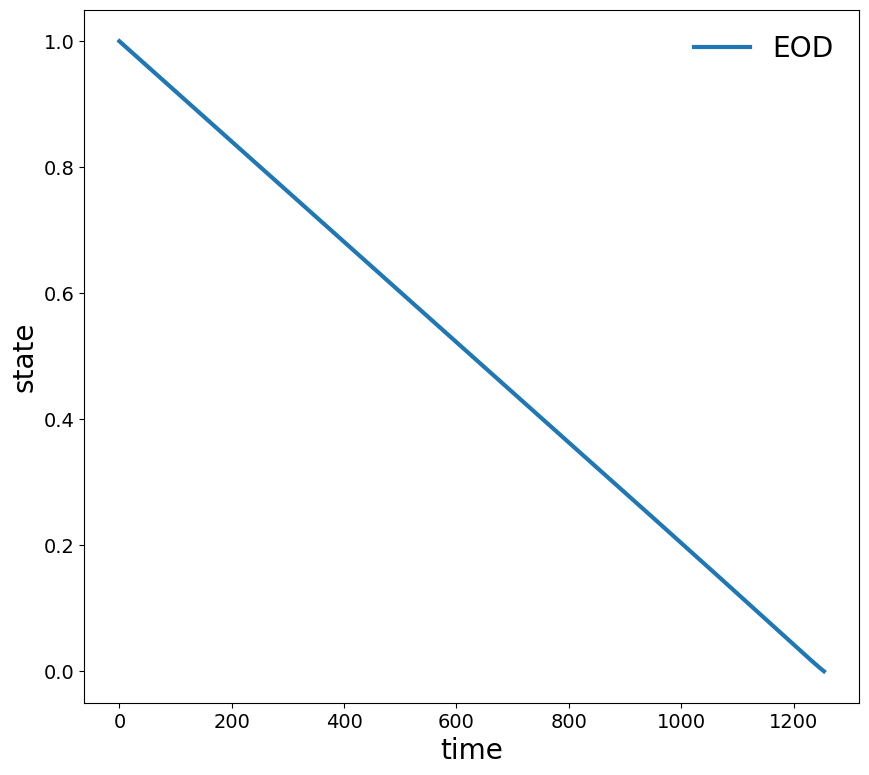

In [133]:
fig = results.event_states.plot()

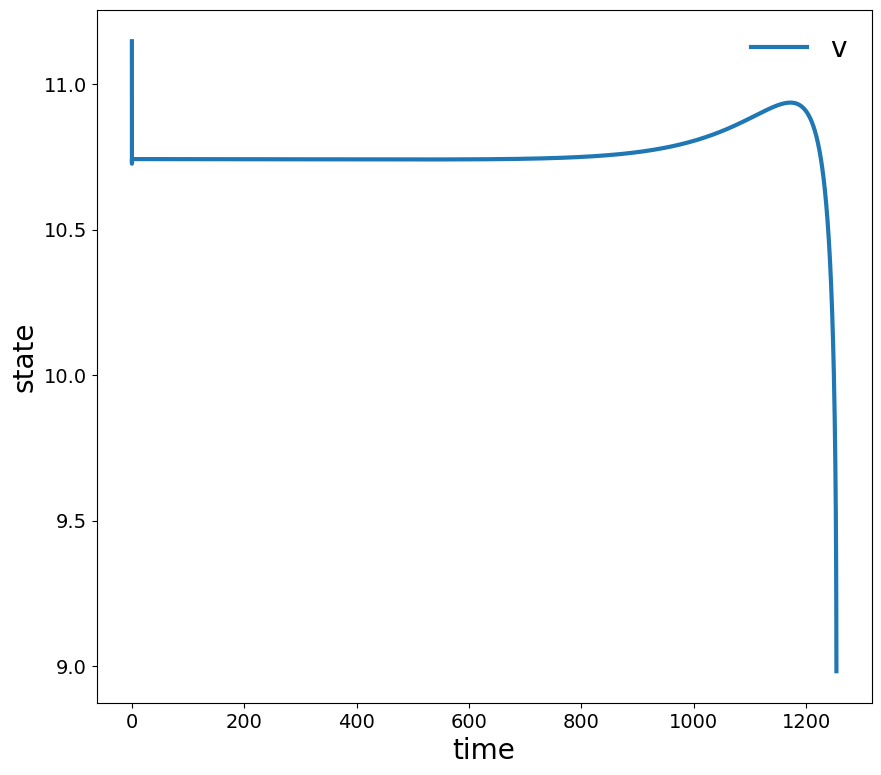

In [134]:
fig = results.outputs.plot()

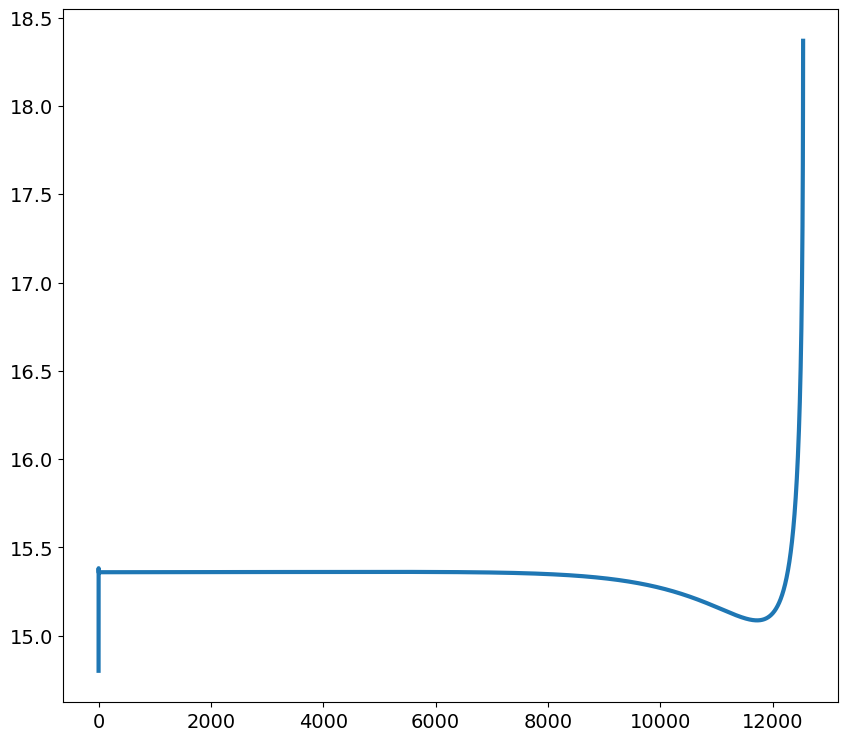

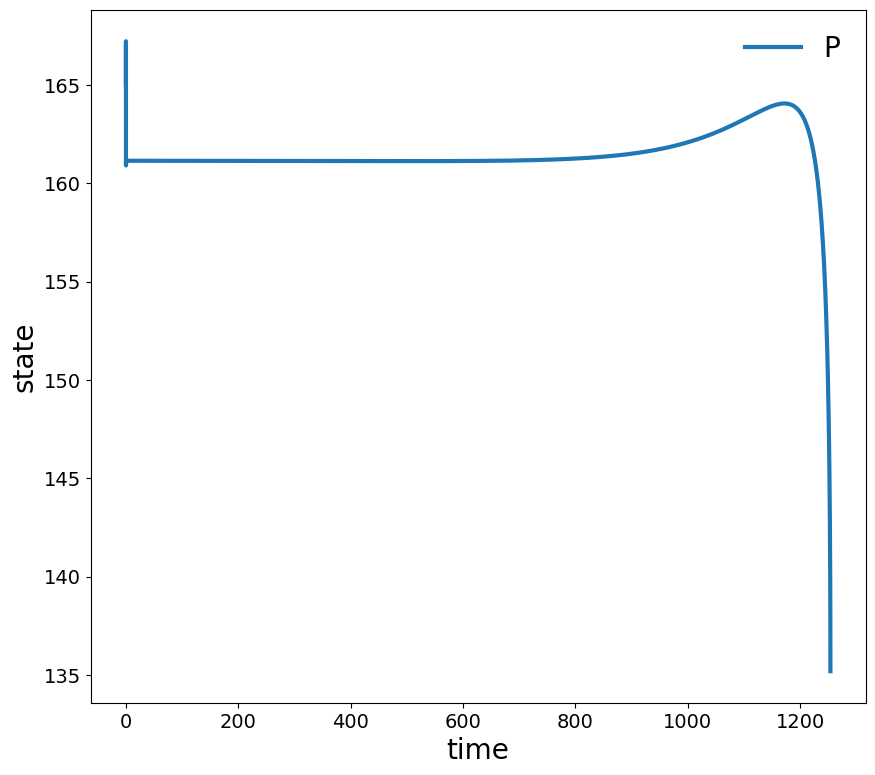

In [137]:
current = [165/z['v'] for z in results.outputs]
import matplotlib.pyplot as plt
fig = plt.plot(current)
fig = results.inputs.plot()

TODO(CT): Use with prediction

## Advanced Capabilities

### Combination Models

https://nasa.github.io/progpy/prog_models_guide.html#combination-models

This section demonstrates how prognostic models can be combined. There are two times in which this is useful: 

1. When combining multiple models of different inter-related systems into one system-of-system model (i.e., [Composite Models](https://nasa.github.io/progpy/api_ref/prog_models/CompositeModel.html)), or
2. Combining multiple models of the same system to be simulated together and aggregated (i.e., [Ensemble Models](https://nasa.github.io/progpy/api_ref/prog_models/EnsembleModel.html) or [Mixture of Expert Models](https://nasa.github.io/progpy/api_ref/progpy/MixtureOfExperts.html)). This is generally done to improve the accuracy of prediction when you have multiple models that each represent part of the behavior or represent a distribution of different behaviors.

For this example we will combine the competing models using a Mixture of Expert Model

In [ ]:
from progpy import MixtureOfExpertsModel

TODO(CT): COMBINE MODELS FROM ABOVE

TODO(CT): Compare performacne

## Closing

https://nasa.github.io/progpy/index.html#contributing-and-partnering